## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
from random import sample
import sklearn.model_selection as skl
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
7689,00002015_000.png,No Finding,0,2015,61,F,AP,3056,2544,0.139000,0.139000,NaN,/data/images_002/images/00002015_000.png
110176,00029986_000.png,No Finding,0,29986,45,M,PA,2021,2021,0.194311,0.194311,NaN,/data/images_012/images/00029986_000.png
96179,00025303_004.png,Atelectasis,4,25303,63,F,PA,2544,3056,0.139000,0.139000,NaN,/data/images_011/images/00025303_004.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column
all_labels = all_xray_df['Finding Labels'].map(lambda x:x.split('|')).tolist()
all_labels = np.unique(list(chain(*all_labels)))
print(all_labels, len(all_labels))
for label in all_labels:
    all_xray_df[label] = all_xray_df['Finding Labels'].map(lambda findings: 1.0 if label in findings else 0.0)
all_xray_df.sample(5)
# Todo

['Atelectasis' 'Cardiomegaly' 'Consolidation' 'Edema' 'Effusion'
 'Emphysema' 'Fibrosis' 'Hernia' 'Infiltration' 'Mass' 'No Finding'
 'Nodule' 'Pleural_Thickening' 'Pneumonia' 'Pneumothorax'] 15


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
69784,00017204_000.png,No Finding,0,17204,45,F,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
38515,00010060_041.png,No Finding,41,10060,58,F,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
100645,00026715_003.png,Effusion|Infiltration,3,26715,51,M,PA,2021,2021,0.194311,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
60093,00014827_005.png,No Finding,5,14827,48,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
11435,00003008_000.png,Fibrosis,0,3008,59,M,PA,2992,2991,0.143000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'].map(lambda val: "Positive" if val == 1.0 else "Negative")

n = len(all_xray_df[all_xray_df['Pneumonia'] == 1.0])
print("We have {} cases from {} cases which have Pneumonia as a finding. That is {}% of whole dataset.".format(n, len(all_xray_df), n/len(all_xray_df)*100))

all_xray_df.head()
# Todo

We have 1431 cases from 112120 cases which have Pneumonia as a finding. That is 1.2763110952550838% of whole dataset.


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Negative
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative


## Create your training and testing data:

In [5]:
def create_splits(df, category):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    train_data, valid_data = skl.train_test_split(df, test_size = 0.2, stratify = df[category], shuffle = True)
    p_inds = list(train_data[train_data.Pneumonia == 1.0].index)
    np_inds = list(train_data[train_data.Pneumonia == 0.0].index)
    #len(p_inds + np_inds)
    np_sample = sample(np_inds, len(p_inds))
    train_data = train_data.loc[p_inds + np_sample]
    
    # Finally, we want to make the balance in our validation set more like 20-80 since 
    # prevelance of Pneumonia may be more in clinical settings
    vp_inds = list(valid_data[valid_data.Pneumonia == 1.0].index)
    vnp_inds = list(valid_data[valid_data.Pneumonia == 0.0].index)
    vnp_sample = sample(vnp_inds, 4*len(vp_inds))
    valid_data = valid_data.loc[vp_inds + vnp_sample]
    print("Fraction of Positive cases in Training set :",train_data.Pneumonia.sum()/len(train_data))
    print("Fraction of Positive cases in Validation set :",valid_data.Pneumonia.sum()/len(valid_data))
    
    # shuffling the dataframes 
    train_data = train_data.sample(frac = 1)
    valid_data = valid_data.sample(frac = 1)
    
    return train_data, valid_data

train_data, valid_data = create_splits(all_xray_df, 'Pneumonia')

Fraction of Positive cases in Training set : 0.5
Fraction of Positive cases in Validation set : 0.2


In [6]:
print(train_data['Pneumonia'].sum()/len(train_data), len(train_data))
train_data.head()

0.5 2290


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
77329,00018996_002.png,Pneumonia,2,18996,22,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Positive
57195,00014200_000.png,Nodule,0,14200,66,M,PA,2874,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Negative
36497,00009617_001.png,No Finding,1,9617,50,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Negative
20877,00005567_025.png,Pneumonia,25,5567,53,M,PA,2734,2945,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Positive
60579,00014956_010.png,Atelectasis|Mass|Nodule|Pneumonia,10,14956,42,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,Positive


In [7]:
print(valid_data['Pneumonia'].sum()/len(valid_data), len(valid_data))
valid_data.head()

0.2 1430


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
45036,00011568_006.png,Atelectasis|Consolidation,6,11568,45,M,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative
69865,00017223_002.png,No Finding,2,17223,59,M,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Negative
25419,00006691_001.png,No Finding,1,6691,38,M,PA,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Negative
43712,00011255_006.png,No Finding,6,11255,56,F,PA,1875,2011,0.194311,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Negative
71087,00017528_001.png,Pleural_Thickening,1,17528,60,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Negative


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [8]:

def my_train_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    
    # here vertical_flip is set to false because it does not represent how images come in the real world.
    my_idg = ImageDataGenerator(rescale = 1./255.0, 
                               horizontal_flip=True,
                               vertical_flip =False,
                               height_shift_range=0.1,
                               width_shift_range=0.1,
                               rotation_range=15,
                               shear_range=0.1,
                               zoom_range=0.1)
    
    
    return my_idg

def my_val_augmentation():
    
    # we don't really want to augment valid images. Because they represent the real data that we have to use our algorithm on
    my_idg = ImageDataGenerator(rescale = 1./255.0)
    return my_idg

def make_train_gen(my_train_idg, train_df, IMG_SIZE = (224,224), batch_size = 64):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = batch_size
                                         )
     
    # Todo

    return train_gen


def make_val_gen(my_val_idg, val_df, IMG_SIZE = (224,224) , batch_size = 64):
    
    val_gen = my_val_idg.flow_from_dataframe(dataframe = val_df, 
                                             directory=None, 
                                             x_col = 'path',
                                             y_col = 'pneumonia_class',
                                             class_mode = 'binary',
                                             target_size = IMG_SIZE, 
                                             batch_size = batch_size) 
    
    # Todo
    return val_gen

In [9]:
IMG_SIZE = (224, 224) # size fo the image after augmentation. This is fed to neural net.
my_train_idg = my_train_augmentation()
my_val_idg = my_val_augmentation()
train_gen = make_train_gen(my_train_idg, train_data, IMG_SIZE, 32)
val_gen = make_val_gen(my_val_idg, valid_data, IMG_SIZE, 32)


Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [10]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

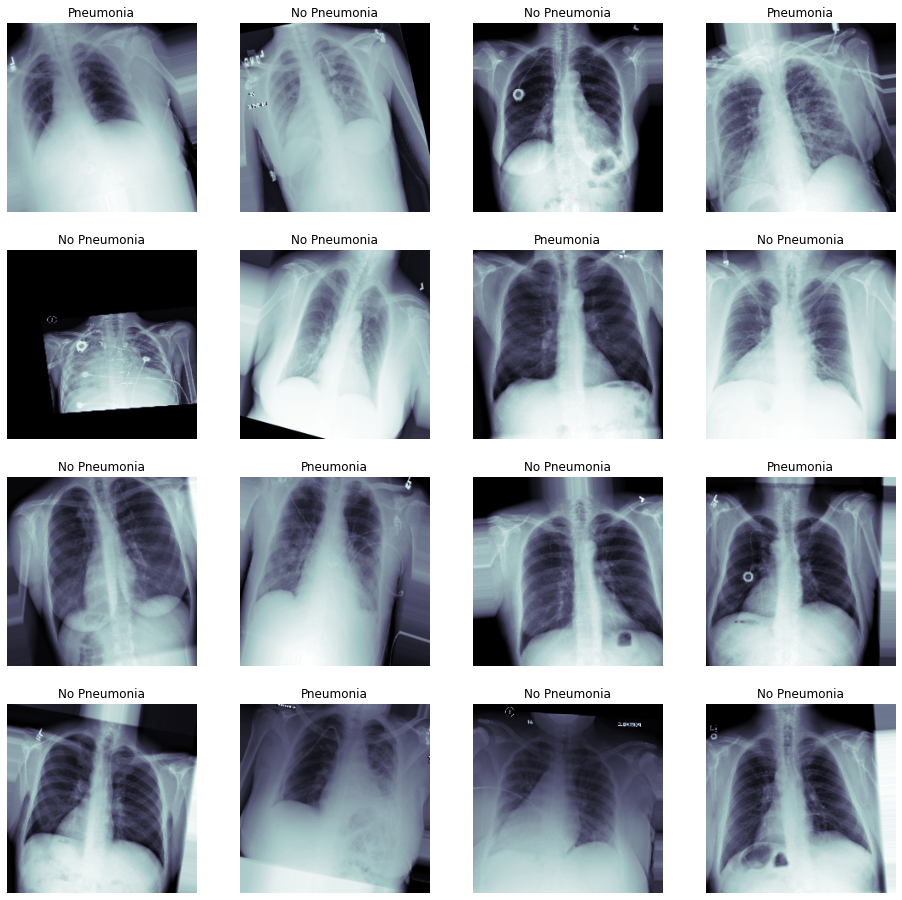

In [11]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [15]:
def load_pretrained_model(lay_of_interest = 'block5_pool', weights = 'imagenet'):
    
    model = VGG16(include_top=True, weights=weights)
    transfer_layer = model.get_layer(lay_of_interest)
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    for layer in vgg_model.layers[0:15]:
        layer.trainable = False
    
    return vgg_model


In [13]:
def build_my_model(vgg_model, lr = 1e-4):
    
    my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    my_model.add(vgg_model)
    my_model.add(Flatten())
    my_model.add(Dropout(0.5))

    my_model.add(Dense(1024, activation='relu'))

    my_model.add(Dropout(0.5))

    my_model.add(Dense(512, activation='relu'))

    my_model.add(Dropout(0.5))

    my_model.add(Dense(256, activation='relu'))

    my_model.add(Dense(1, activation = 'sigmoid'))
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    optimizer = Adam(lr=1e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    
    # Todo
    my_model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [14]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [16]:
## train your model

# Todo
vgg_model = load_pretrained_model()
my_model = build_my_model(vgg_model)

history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 50, 
                          callbacks = callbacks_list)

553467904/553467096 [==============================] - 7s 0us/step
Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 72 steps, validate on 32 samples
Epoch 1/50
71/72 [============================>.] - ETA: 0s - loss: 0.7422 - binary_accuracy: 0.4787
Epoch 00001: val_loss improved from inf to 0.69183, saving model to xray_class_my_model.best.hdf5
72/72 [==============================] - 70s 973ms/step - loss: 0.7415 - binary_accuracy: 0.4790 - val_loss: 0.6918 - val_binary_accuracy: 0.6562
Epoch 2/50
71/72 [============================>.] - ETA: 0s - loss: 0.6915 - binary_accuracy: 0.5173
Epoch 00002: val_loss did not improve from 0.69183
72/72 [==============================] - 58s 802ms/step - loss: 0.6914 - binary_accuracy: 0.5162 - val_loss: 0.7730 - val_binary_accuracy: 0.2500
Epoch 3/50
71/72 [============================>.] - ETA: 0s - loss: 0.6918 - binary_accuracy: 0.5310
Epoch 00003: val_loss improved from 0.69183 t

Epoch 25/50
71/72 [============================>.] - ETA: 0s - loss: 0.6143 - binary_accuracy: 0.6740
Epoch 00025: val_loss did not improve from 0.51194
72/72 [==============================] - 60s 829ms/step - loss: 0.6155 - binary_accuracy: 0.6725 - val_loss: 0.5401 - val_binary_accuracy: 0.7188
Epoch 26/50
71/72 [============================>.] - ETA: 0s - loss: 0.6031 - binary_accuracy: 0.6727
Epoch 00026: val_loss did not improve from 0.51194
72/72 [==============================] - 61s 849ms/step - loss: 0.6032 - binary_accuracy: 0.6734 - val_loss: 0.5824 - val_binary_accuracy: 0.7188
Epoch 27/50
71/72 [============================>.] - ETA: 0s - loss: 0.6056 - binary_accuracy: 0.6754
Epoch 00027: val_loss did not improve from 0.51194
72/72 [==============================] - 60s 835ms/step - loss: 0.6063 - binary_accuracy: 0.6742 - val_loss: 0.5283 - val_binary_accuracy: 0.7188
Epoch 28/50
71/72 [============================>.] - ETA: 0s - loss: 0.6036 - binary_accuracy: 0.6776
E

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [16]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.

#if already trained and have same weights, no need to train again, just build the model and load the weights
vgg_model = load_pretrained_model()
my_model = build_my_model(vgg_model)

my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

32/32 [==============================] - 18s 557ms/sample


In [22]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    fig, c_ax = plt.subplots(1,1, figsize = (8, 8))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    c_ax.set_title('AUC curve')

## what other performance statistics do you want to include here besides AUC? 


def plot_precision_recall_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (8, 8))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')
    c_ax.set_title('precision_recall_curve')

def  calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)
    
#Also consider plotting the history of your model training:

def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure(figsize = (8,8))
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.
def plot_f1(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (6, 6))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    thresholds = list(thresholds)
    thresholds.append(1)
    f1_scores = []
    for p, r in zip(precision, recall):
        f1 = calc_f1(p,r)
        f1_scores.append(f1)
    c_ax.plot(thresholds, f1_scores)
    c_ax.set_xlabel('Thresholds')
    c_ax.set_ylabel('F1_score')
    c_ax.set_title('F1 vs threshold')
    return (f1_scores, thresholds)

def select_threshold(f1_scores, thresholds):
    """Select the threshold with best F1 score"""
    max_ind = f1_scores.index(max(f1_scores))
    return thresholds[max_ind]

The threshold with the best F1 score is 0.7144732


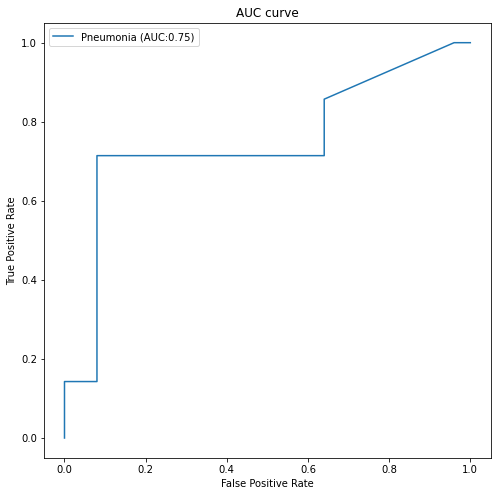

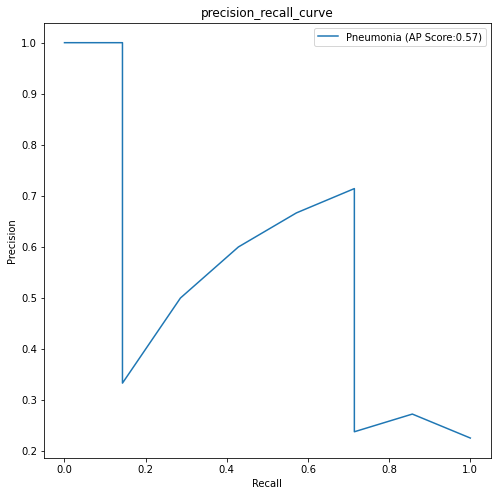

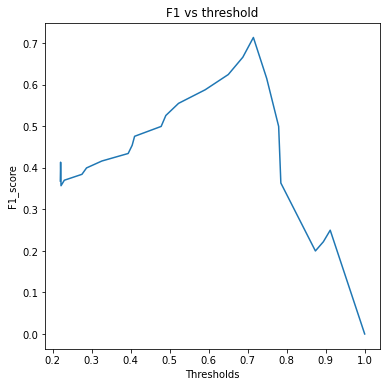

In [24]:
# if using saved weights, then only run this cell. Otherwise run the cell below to see training statistics
## plot figures
plot_auc(valY, pred_Y)
plot_precision_recall_curve(valY, pred_Y)
f1_scores, thresholds = plot_f1(valY, pred_Y)
th = select_threshold(f1_scores, thresholds)
print("The threshold with the best F1 score is", th)

#### Results:
These are the results of our algorithm performing on this validation set.
1. AUC score of 0.75 which is a good score for this task.
2. AP score of 0.5
3. Top F1 score of 0.7 

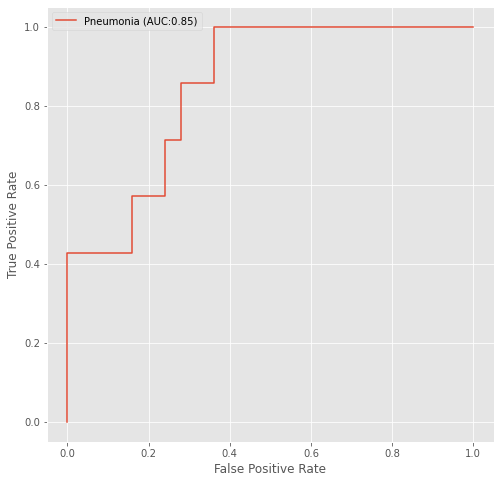

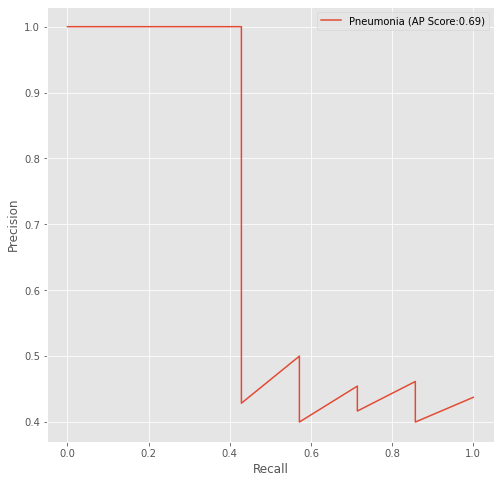

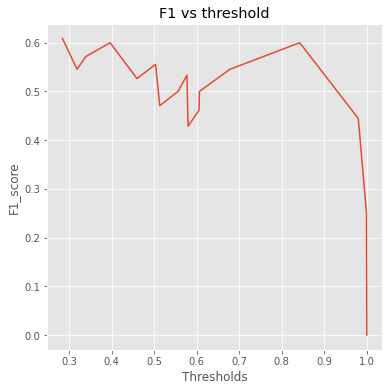

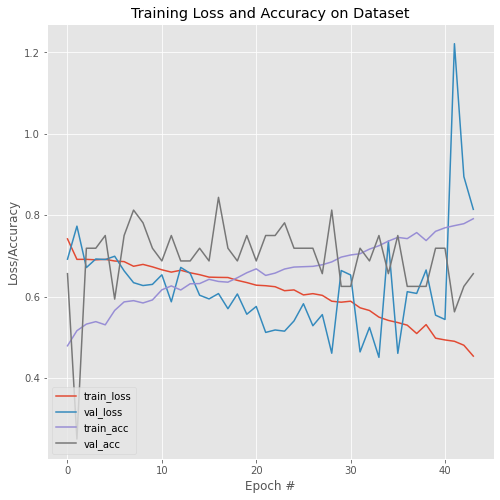

In [37]:
## plot figures
# only run this 
plot_auc(valY, pred_Y)
plot_precision_recall_curve(valY, pred_Y)
plot_f1(valY, pred_Y)
plot_history(history)
# Todo

As we can see,  Our model training loss decreased with time. The validation loss also decreased till approx 35 epochs and after 40 epochs it increased suggesting possible overfitting.

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 


I am going to choose **F1 score** as the evaluation metric. Since In [literature](https://arxiv.org/pdf/1711.05225.pdf),  the F1 score achieved by a group of radiologists **(silver standard) is 0.387** and hence, we can do a direct comparision with it.

The title of each X-ray is (Truth, Prediction)


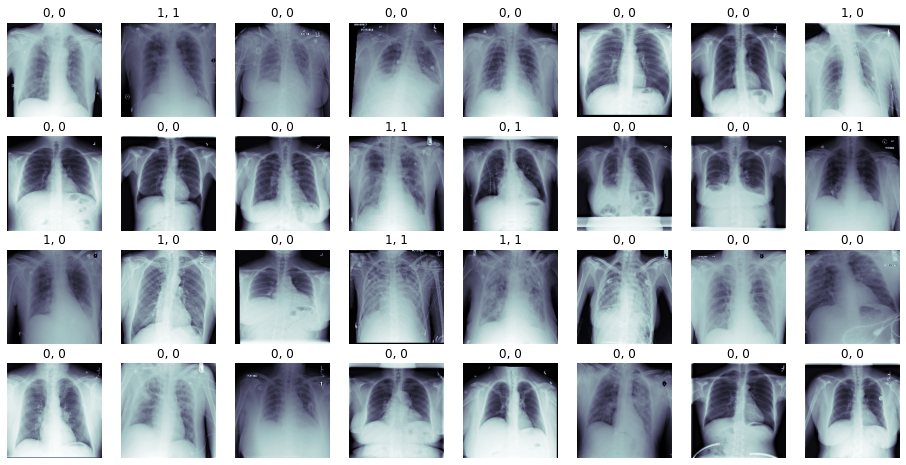

In [32]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo
print("The title of each X-ray is (Truth, Prediction)")
fig, m_axs = plt.subplots(4, 8, figsize = (16, 8))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:32], valY[0:32], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > th:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > th: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [ ]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)